In [1]:
from jax import grad, vmap

In [2]:
import jax.numpy as jnp

In [3]:
import numpy as np

In [4]:
x_array_jnp = jnp.array([1., 2., 3.])
x_array_np = np.array([1, 2, 3])

print(f"Type  of numpy array: {type(x_array_np)}")
print(f"Type  of jax-numpy array: {type(x_array_jnp)}")

Type  of numpy array: <class 'numpy.ndarray'>
Type  of jax-numpy array: <class 'jaxlib.xla_extension.ArrayImpl'>


The same array can be defined by just converting previously defined x_array_np, althogh in some cases JAX does not operate with integers, thus the values need to be converted to floats.

In [6]:
jax_np_array = jnp.array(x_array_np.astype('float32'))
print(jax_np_array)
print(type(jax_np_array))

[1. 2. 3.]
<class 'jaxlib.xla_extension.ArrayImpl'>


In most of the cases thesame operators and functions are applicable to them as in the original numpy 

In [7]:
print(jax_np_array * 2)
print(jax_np_array[2])

[2. 4. 6.]
3.0


But in the case of trying to assign a new value to an element, you will get an error

In [8]:
try:
    jax_np_array[2] = 3.
except Exception as e:
    print(e)

JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


To assign a new value to an element, you need to apply functions .at[i], stating which element to update, and .set(value) to set a new value. This functions also update out-of-place, the updated array is returned as a new array and the original array is not modified by the update.

In [9]:
y_array_jnp = x_array_jnp.at[2].set(4.0)
print(y_array_jnp)

[1. 2. 4.]


Although, some of the jax functions will work with arrays defined with np and jnp. 

In [10]:
print(jnp.log(x_array_np))
print(jnp.log(x_array_jnp))

[0.        0.6931472 1.0986123]
[0.        0.6931472 1.0986123]


### AUTOMATIC DIFFERENTIATION WITH JAX

Time to do automatic differentiation with JAX. The following code will calculate the derivative of the function  𝑓(𝑥)=𝑥2
  at the point  𝑥=3
 :

In [11]:
def f(x):
    return x**2

print(f(3))

9


In [12]:
print(f"Function value at x = 3: {f(3.0)}")
print(f"Derivative value at x = 3: {grad(f)(3.0)}")

Function value at x = 3: 9.0
Derivative value at x = 3: 6.0


Lets apply the grad function to an array, calculating the derivative for each of its elements.

In [13]:
try:
    grad(f)(x_array_jnp)
except Exception as e:
    print(e)

Gradient only defined for scalar-output functions. Output had shape: (3,).


The issue above is a broadcasting issue, which can be solved using the vmap function

In [16]:
dfdx_jax_vmap = vmap(grad(f))(x_array_jnp)
print(dfdx_jax_vmap)

[2. 4. 6.]


In [19]:
def dfdx(x):
    return 2*x

print(dfdx(3))

6


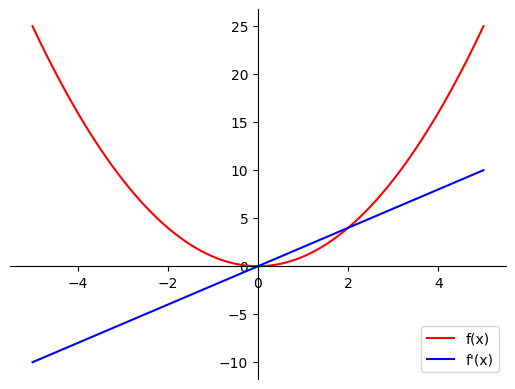

In [20]:
import matplotlib.pyplot as plt

# Output of plotting commands is displayed inline within the Jupyter notebook.
%matplotlib inline

def plot_f1_and_f2(f1, f2=None, x_min=-5, x_max=5, label1="f(x)", label2="f'(x)"):
    x = np.linspace(x_min, x_max,100)

    # Setting the axes at the centre.
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.plot(x, f1(x), 'r', label=label1)
    if not f2 is None:
        # If f2 is an array, it is passed as it is to be plotted as unlinked points.
        # If f2 is a function, f2(x) needs to be passed to plot it.        
        if isinstance(f2, np.ndarray):
            plt.plot(x, f2, 'bo', markersize=3, label=label2,)
        else:
            plt.plot(x, f2(x), 'b', label=label2)
    plt.legend()

    plt.show()
    
plot_f1_and_f2(f, dfdx)

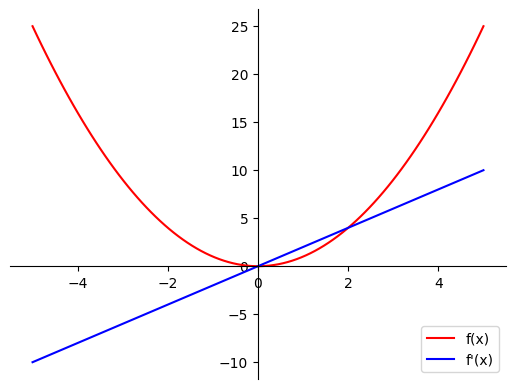

In [21]:
plot_f1_and_f2(f, vmap(grad(f)))

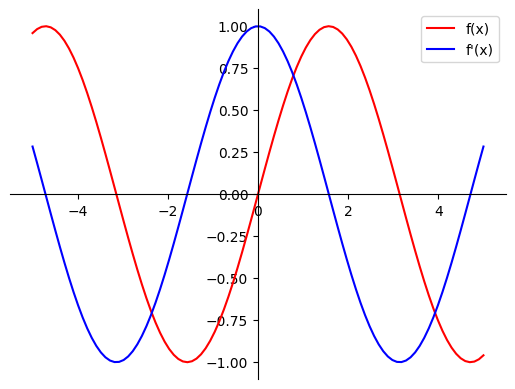

In [28]:
def g(x):
#     return x**3
#     return 2*x**3 - 3*x**2 + 5
#     return 1/x
#     return jnp.exp(x)
#     return jnp.log(x)
     return jnp.sin(x)
#     return jnp.cos(x)
#    return jnp.abs(x)
#     return jnp.abs(x)+jnp.sin(x)*jnp.cos(x)

plot_f1_and_f2(g, vmap(grad(g)))

### COMPUTATIONAL EFFICIENCY OF SYMBOLC NUMERICAL AND AUTOMATIC DIFFERENTIATION

In [34]:
# List of symbols.
x, y = symbols('x y')
# Definition of the expression.
expr = 2 * x**2 - x * y
expr

2*x**2 - x*y

In [35]:
from sympy import *
from sympy.utilities.lambdify import lambdify
#f_symb_numpy = lambdify(x, f_symb, 'numpy')

In [36]:
import timeit, time

x_array_large = np.linspace(-5, 5, 1000000)

tic_symb = time.time()
res_symb = lambdify(x, diff(f(x),x),'numpy')(x_array_large)
toc_symb = time.time()
time_symb = 1000 * (toc_symb - tic_symb)  # Time in ms.

tic_numerical = time.time()
res_numerical = np.gradient(f(x_array_large),x_array_large)
toc_numerical = time.time()
time_numerical = 1000 * (toc_numerical - tic_numerical)

tic_jax = time.time()
res_jax = vmap(grad(f))(jnp.array(x_array_large.astype('float32')))
toc_jax = time.time()
time_jax = 1000 * (toc_jax - tic_jax)

print(f"Results\nSymbolic Differentiation:\n{res_symb}\n" + 
      f"Numerical Differentiation:\n{res_numerical}\n" + 
      f"Automatic Differentiation:\n{res_jax}")

print(f"\n\nTime\nSymbolic Differentiation:\n{time_symb} ms\n" + 
      f"Numerical Differentiation:\n{time_numerical} ms\n" + 
      f"Automatic Differentiation:\n{time_jax} ms")

Results
Symbolic Differentiation:
[-10.       -9.99998  -9.99996 ...   9.99996   9.99998  10.     ]
Numerical Differentiation:
[-9.99999 -9.99998 -9.99996 ...  9.99996  9.99998  9.99999]
Automatic Differentiation:
[-10.       -9.99998  -9.99996 ...   9.99996   9.99998  10.     ]


Time
Symbolic Differentiation:
646.5339660644531 ms
Numerical Differentiation:
57.69181251525879 ms
Automatic Differentiation:
121.72198295593262 ms
